# Testes de Estacionariedade

In [7]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss
import numpy as np
import pandas as pd
from yahoofinancials import YahooFinancials
import matplotlib.pyplot as plt

In [8]:
# Exemplo de teste Dickey-Fuller
data = np.random.rand(100)
result = adfuller(data)
print('Estatística do teste de Dickey-Fuller:', result[0])
print('Valor p:', result[1])

Estatística do teste de Dickey-Fuller: -9.230811801944007
Valor p: 1.6803624825472775e-15


In [9]:
result

(-9.230811801944007,
 1.6803624825472775e-15,
 0,
 99,
 {'1%': -3.498198082189098,
  '5%': -2.891208211860468,
  '10%': -2.5825959973472097},
 41.31942039492492)

## Aplicando o teste de Dickey-Fuller na série de Soja (Yahoo Finance)

In [10]:
lista_codigos = ['ZS=F']  #soja grão
dados_yahoo = YahooFinancials(lista_codigos)
preco_diario = dados_yahoo.get_historical_price_data('1999-01-01', '2024-02-07', 'daily')
precos_soja = pd.DataFrame({a: {x['formatted_date']: x['adjclose'] for x in preco_diario[a]['prices']} for a in lista_codigos})

# Pré-processamento
precos_soja.reset_index(inplace=True)
precos_soja = precos_soja.rename(columns={'index':'Data'}).copy()
precos_soja.set_index('Data', inplace=True)
precos_soja.index = pd.to_datetime(precos_soja.index)

precos_soja

,ZS=F
Data,
2000-09-15,493.75
2000-09-18,484.00
2000-09-19,484.25
2000-09-20,483.25
2000-09-21,486.50
...,...
2024-01-31,1222.25
2024-02-01,1203.25
2024-02-02,1188.50


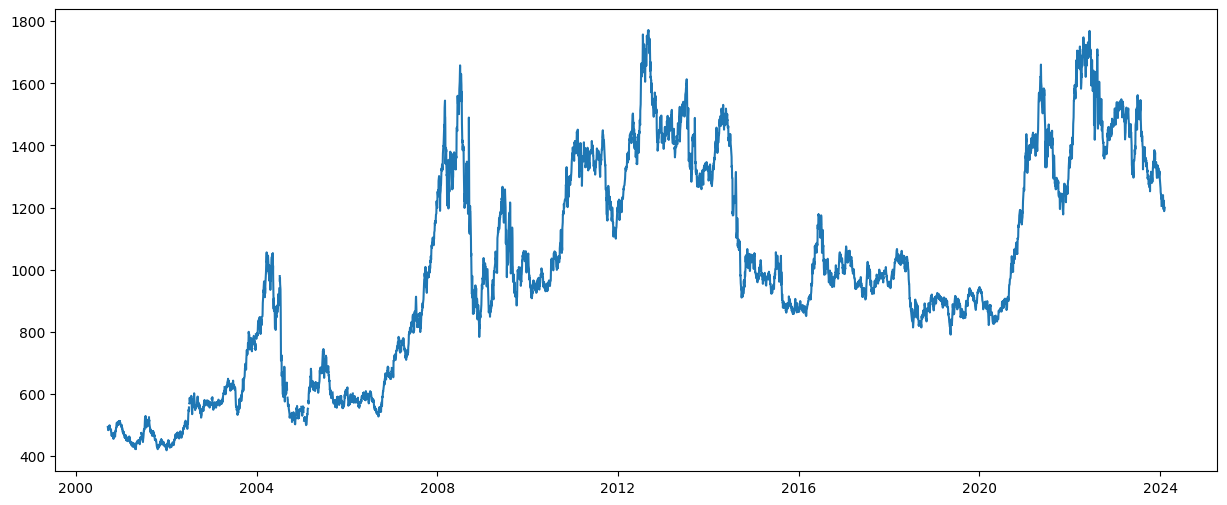

In [11]:
plt.figure(figsize=(15,6))
plt.plot(precos_soja)
plt.show()

In [12]:
dados_soja = precos_soja.dropna()

In [13]:
def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput[f"Critical Value ({key})"] = value
    print(dfoutput)

In [14]:
adf_test(dados_soja)    #série não estacionária, p-value > 0.05

Results of Dickey-Fuller Test:
Test Statistic                   -2.291668
p-value                           0.174669
#Lags Used                       23.000000
Number of Observations Used    5860.000000
Critical Value (1%)              -3.431466
Critical Value (5%)              -2.862033
Critical Value (10%)             -2.567033
dtype: float64


## Teste Kwiatkowski-Phillips-Schmidt-Shin (KPSS)

In [15]:
def kpss_test(x, h0_type='c'):
  indices = ['Estatística do teste', 'valor-p', '# de Lags']
  kpss_test = kpss(x, regression=h0_type, nlags="legacy")
  results = pd.Series(kpss_test[0:3], index=indices)
  print('H0: A série temporal é estacionária (caso valor-p > 0.05)')
  for key, value in kpss_test[3].items():
    results[f'Critical Value ({key})'] = value
  
  return results

In [16]:
kpss_test(dados_soja) #série não estacionária, p-value < 0.05

H0: A série temporal é estacionária (caso valor-p > 0.05)


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_15540\699921468.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_test = kpss(x, regression=h0_type, nlags="legacy")


Estatística do teste      7.533753
valor-p                   0.010000
# de Lags                34.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64

## Estatísticas descritivas

In [17]:
est_soja = dados_soja.describe()
print('Estatísticas descritivas:')
print(est_soja)

Estatísticas descritivas:
              ZS=F
count  5884.000000
mean   1002.868542
std     337.480799
min     418.500000
25%     751.937500
50%     971.500000
75%    1308.062500
max    1771.000000


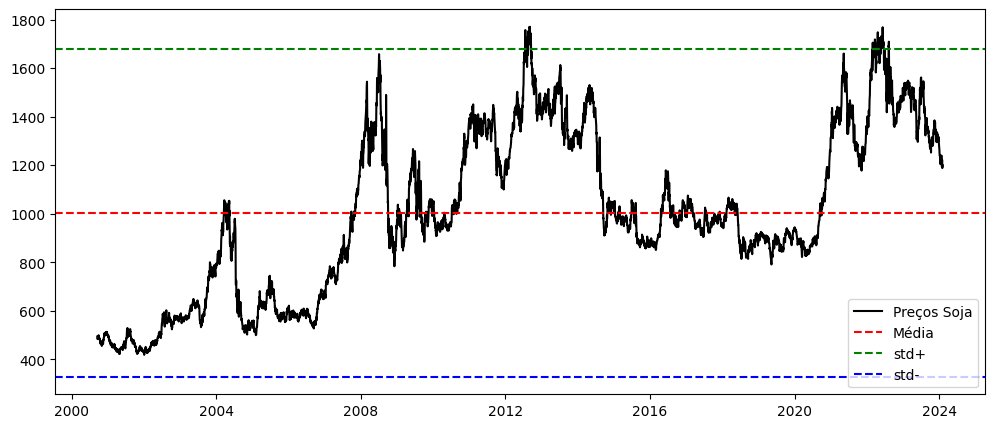

In [18]:
media_soja = dados_soja.mean().values
desviop_soja = dados_soja.std().values

plt.figure(figsize=(12,5))
plt.plot(dados_soja, label='Preços Soja', color='black')
plt.axhline(media_soja, color='r', linestyle='dashed', label='Média')
plt.axhline(media_soja + 2*desviop_soja, color='g', linestyle='dashed', label='std+')
plt.axhline(media_soja - 2*desviop_soja, color='b', linestyle='dashed', label='std-')
plt.legend(loc='lower right')
plt.show()   #faz sentido esse plot sendo a série não-estacionária? aqui encaixaria os modelos de samuelson e bachelier?

### Boxplot e histograma

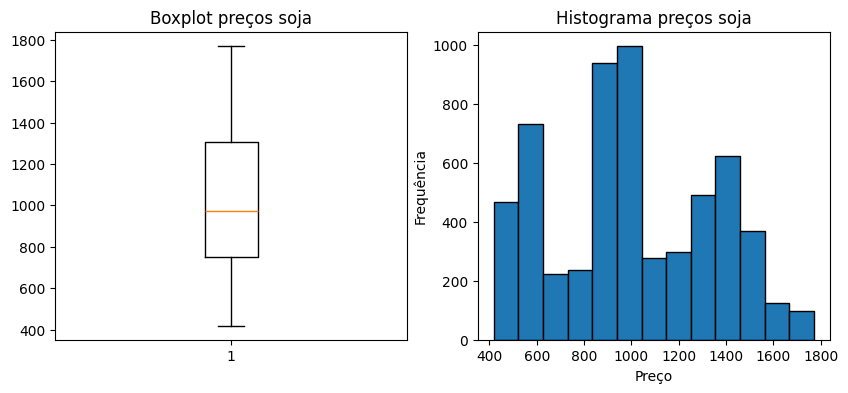

In [20]:
# Criar uma figura com subplots para boxplot e histograma
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

# Boxplot
ax[0].boxplot(dados_soja, showfliers=True)
ax[0].set_title('Boxplot preços soja')

# Histograma
N = dados_soja.size
bins = int(1 + np.log2(N))  #Regra de Sturges
ax[1].hist(dados_soja, bins=bins, edgecolor='black')
ax[1].set_title('Histograma preços soja')
ax[1].set_ylabel('Frequência')
ax[1].set_xlabel('Preço')

plt.show()